# Beating Airbnb: Predicting New User Bookings

## Team Members

- Alex Fabiano 
- Michael Clawson
- Elijah Broadbent 


## Problem Statement



With 34,000+ cities across 190+ countries, Airbnb users have a multitude of destinations from which to choose.  This vast array of possibilities creates problems for both users and Airbnb. New users may suffer choice overload and prolong their first booking. Irregular and prolonged first bookings can cause demand lags and inhibit demand predictability for Airbnb.
	
The goal of this data project is to accurately predict where new users will book their first Airbnb. This will enable Airbnb to share more personalized content and better forecast demand as well as improve user experience.


## Strategy

After merging our data and doing a minimal amount of initial cleaning, we will use a K-Neighbors Classifier to get a naive baseline for our classification problem. From there we will modify our cleaning as needed to account for outliers, missing data, and optimal control variables in a more robust fashion. Other models we plan to consult include Random Forest, regression, and Gradient Boosting. Depending on the results we obtain from these methods we can complicate our approach using tiered-ensembles of multiple models.  Without further ado, let's take a look at our data.

## Data

In [53]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn import metrics
import pytz
import datetime
import calendar
# from sklearn.metrics import f1_score, classification_report, accuracy_score, make_scorer
plt.rcParams['figure.figsize'] = [10,8]

Include reasoning for leaving out the countries, sessions, and age_gender_buckets, or remove entirely. Only we know they were there in the first place.

In [3]:
test = pd.read_csv('test_users.csv')
users = pd.read_csv('train_users_2.csv')

Let's read in our user set:

In [4]:
users.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


Text(0,0.5,'Signup Flow')

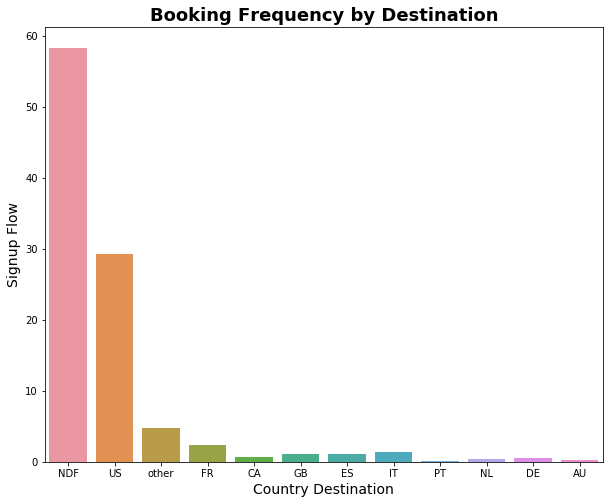

In [7]:
ax = sns.barplot(x="country_destination", y="signup_flow", data=users, estimator=lambda x: len(x) / len(users) * 100)
plt.title("Booking Frequency by Destination", fontsize=18, fontweight='bold')
plt.xlabel("Country Destination",fontsize=14)
plt.ylabel("Signup Flow", fontsize=14)
#Here I pass 'signup_flow as my y variable simply because it is a numeric variable.  
#This allows me to normalize the barchart for country_destination counts and checks out with the percentage values 
#obtained from our value_counts command in a previous version.

NDF stands for No Destination Finalized.  It appears that nearly 60% of the domestic users in our data set ultimately exit the browsing session without making a booking.  Of the users who do book, the majority choose to visit other locations within the United States.  To predict what bookings users will make, we will first create a model designed to predict whether a user will end up booking a destination at all.

**Make Train/Test Split for Binary Classification Model**

In [8]:
#Create variable for whether a user booked at all
users['Booked?'] = np.where(users['date_first_booking'].isnull(), 0, 1) 
target = users['Booked?']
target2 = users['country_destination']
xtrain, xtest, ytrain, ytest = train_test_split(users.copy(), target, test_size=0.2, random_state=42)

By splitting training data into two pieces we will be able to train our model to run properly on the first piece and then test it on the second to gauge how our model performs out of sample.  We can now inspect the training split more closely to prepare it for analysis.

## Data Cleaning and Feature Engineering

Let's take a look our data types:

In [9]:
xtrain.dtypes

id                          object
date_account_created        object
timestamp_first_active       int64
date_first_booking          object
gender                      object
age                        float64
signup_method               object
signup_flow                  int64
language                    object
affiliate_channel           object
affiliate_provider          object
first_affiliate_tracked     object
signup_app                  object
first_device_type           object
first_browser               object
country_destination         object
Booked?                      int64
dtype: object

We have a lot of object types in our data that will need to be transformed if we choose to use them.  Let's set aside the variables we want to drop and the ones we want to convert into dummy variables.

In [10]:
# Create drop and dummy arrays
drop = []
dummies = []

In [11]:
# Displays the columns with null values and the percent of null values for each column
print("Columns\t\t\t % Null")
xtrain[xtrain.columns[xtrain.isnull().any()]].isnull().sum()/len(xtrain)

Columns			 % Null


date_first_booking         0.583860
age                        0.412573
first_affiliate_tracked    0.028789
dtype: float64

Date of booking null values indicate that no booking was ever made, so a high proportion of nulls in this category is no surprise. Age is the only glaring null-value issue with the data, as over 30% of values are missing. We may be able to find a way to fill these values with the average age conditional on the users other observable characteristics; e.g. female mac owners who use chrome.

In [12]:
drop.extend(['Booked?','country_destination','id','date_first_booking'])

Let's inspect each of these features, one by one.

**Date Account Created**

In [15]:
xtrain.date_account_created.head()# Need to extract usable variables

139642    2014-01-09
519       2010-05-04
120664    2013-10-30
84733     2013-06-18
183255    2014-05-01
Name: date_account_created, dtype: object

We need to convert this variable into a date time so that we can extract the relevant information we need for analysis.  We will then create quantitative variables corresponding to year, month, and day of the week.

In [16]:
xtrain.date_account_created = pd.to_datetime(xtrain.date_account_created) #Casts object as datetime
xtest.date_account_created = pd.to_datetime(xtest.date_account_created)
test.date_account_created = pd.to_datetime(test.date_account_created)

In [17]:
# Create indicators for day of week (0=Mon, 6=Sun) account was created
xtrain['day_of_week_created'] = xtrain.date_account_created.dt.weekday
xtest['day_of_week_created'] = xtest.date_account_created.dt.weekday
test['day_of_week_created'] = test.date_account_created.dt.weekday
# Create indicators for day of month (0 through 31), month (0 through 12), and year account created
xtrain['day_of_month_created'] = xtrain['date_account_created'].dt.day
xtest['day_of_month_created'] = xtest['date_account_created'].dt.day
test['day_of_month_created'] = test['date_account_created'].dt.day
xtrain['month_created'] = xtrain['date_account_created'].dt.month
xtest['month_created'] = xtest['date_account_created'].dt.month
test['month_created'] = test['date_account_created'].dt.month
xtrain['year_created'] = xtrain['date_account_created'].dt.year
xtest['year_created'] = xtest['date_account_created'].dt.year
test['year_created'] = test['date_account_created'].dt.year

In addition to deconstructing the date_account_created variable, we created a variable that measures how old the account is relative to the others. This is done by subtracting date_account_created by a new variable called "today." Afterwards, these variables are added either to the dummy or the drop list.

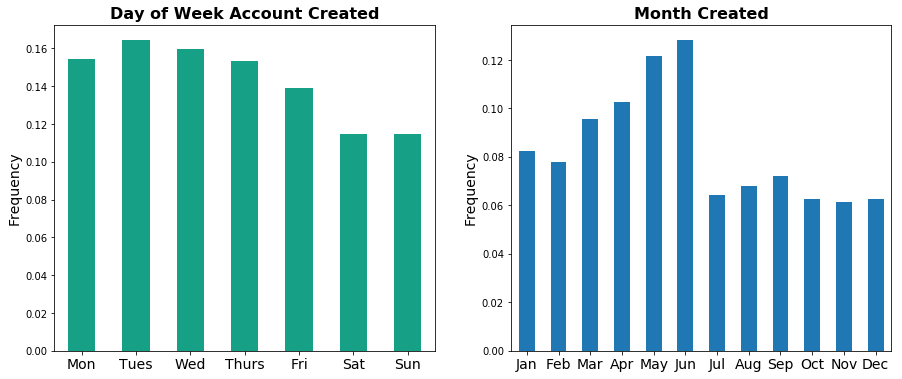

In [83]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
xtrain.day_of_week_created.value_counts(normalize=1).sort_index().plot(kind='bar',x=[0,1,2,3,4,5,6],color='#16A085')
plt.title('Day of Week Account Created', fontsize=16,fontweight='bold')
plt.xticks(np.arange(0,7,1),['Mon','Tues','Wed','Thurs','Fri','Sat','Sun'], rotation=0, fontsize=14)
plt.ylabel('Frequency',fontsize=14)
plt.subplot(1,2,2)
xtrain.month_created.value_counts(normalize=1).sort_index().plot(kind='bar',x=np.arange(0,12,1))
plt.title('Month Created',fontsize=16,fontweight='bold')
plt.xticks(np.arange(0,12,1), calendar.month_abbr[1:],rotation=0,fontsize=14)
plt.ylabel('Frequency',fontsize=14)
plt.show()

In [155]:
drop.append('date_account_created')
dummies.extend(['day_of_week_created','month_created'])

In [156]:
#create a today variable, which we will turn into a datetime and subtract from our date_account_created var
xtrain['today'] = datetime.date.today()
xtest['today'] = datetime.date.today()
test['today'] = datetime.date.today()
xtrain.today = pd.to_datetime(xtrain.today)
xtest.today = pd.to_datetime(xtest.today)
test.today = pd.to_datetime(test.today)

#subtract today from date_account_created to get account_life
xtrain['account_life'] = xtrain['today'].sub(xtrain['date_account_created'], axis=0)
xtest['account_life'] = xtest['today'].sub(xtest['date_account_created'], axis=0)
test['account_life'] = test['today'].sub(test['date_account_created'], axis=0)

#assign account_life var to 5 equal bins, will be created when it is appended to the dummy dataframe.
xtrain['account_life_bins'] = pd.qcut(xtrain['account_life'], 5, labels=False)
xtest['account_life_bins'] = pd.qcut(xtest['account_life'], 5, labels=False)
test['account_life_bins'] = pd.qcut(test['account_life'], 5, labels=False)

#appending to dummies df
dummies.append('account_life_bins')
#drop unnecessary columns
drop.extend(['today','account_life','date_account_created'])

NameError: name 'datetime' is not defined

In [402]:
**Gender**

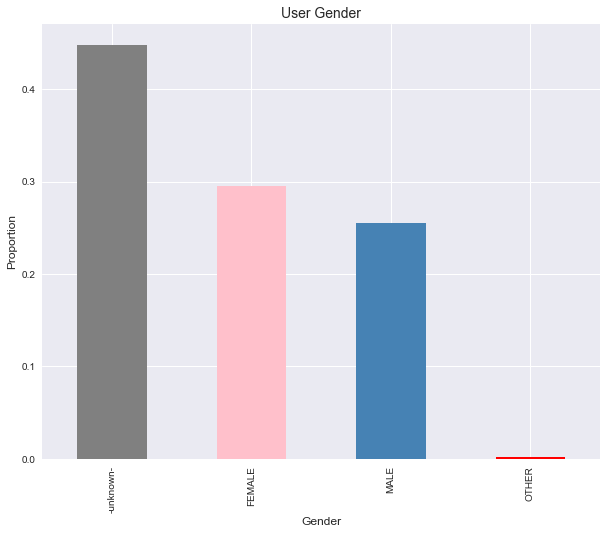

In [157]:
xtrain['gender'].value_counts(normalize=True, dropna=False).plot(kind='bar', color=['gray','pink','#4682B4','red'])
plt.title('User Gender', fontsize=14)
plt.xlabel('Gender', fontsize=12)
plt.ylabel('Proportion', fontsize=12)

Unknown should be kept as a variable, and should not try to fill, given that it is very likely that the model will see unknown genders in the test set. 

In [158]:
dummies.append('gender')#??? only make dummies for 3 of them ('drop_first=True' makes k-1 dummies)

**Age**

In [159]:
xtrain.age.describe()

count    100309.000000
mean         49.658186
std         155.692226
min           1.000000
25%          28.000000
50%          34.000000
75%          43.000000
max        2014.000000
Name: age, dtype: float64

In [160]:
print("% Individuals older than 100: {}".format(sum((xtrain.age > 100)/len(xtrain.age)).round(4)))
print("% Individuals younger than 18: {}".format((sum(xtrain.age < 18)/len(xtrain.age)).round(4)))

% Individuals older than 100: 0.011
% Individuals younger than 18: 0.0007


According to the age distribution statistics, it appears that the data contains individuals with implausible ages exceeding 120 years. We may be better suited to only include individuals under the age of 100 in our analysis and modeling.

In [161]:
# Statistics on individuals with age less than 100
xtrain[xtrain.age<100]['age'].describe()

count    98423.000000
mean        36.522988
std         11.654536
min          1.000000
25%         28.000000
50%         34.000000
75%         42.000000
max         99.000000
Name: age, dtype: float64

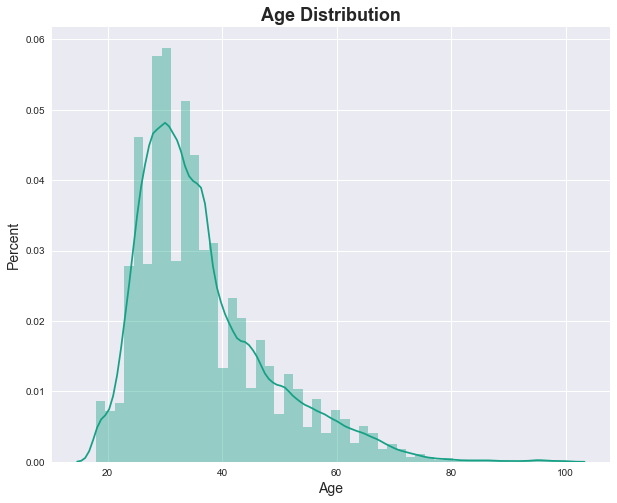

In [162]:
train_mean_age = xtrain[(xtrain.age<100) & (xtrain.age>18)].age.mean()
sns.distplot(xtrain['age'].apply(lambda x : train_mean_age if x>100 or x < 18 else x).dropna(), color='#16A085')
plt.xlabel('Age', fontsize=14)
plt.ylabel('Percent', fontsize=14)
plt.title('Age Distribution', fontsize=18, fontweight='bold')

Most of our dataset is comprised of 25-40-year-olds, and there is a small number of users that are younger than Airbnb terms of service allow to book rooms.  We will also have to do address the bizarre ages in the thousands.

In [163]:
#Change all unusable ages to NaN:
xtrain.loc[xtrain.age > 95, 'age'] = np.nan
xtrain.loc[xtrain.age < 18, 'age'] = np.nan
xtest.loc[xtest.age > 95, 'age'] = np.nan
xtest.loc[xtest.age < 18, 'age'] = np.nan
test.loc[test.age > 95, 'age'] = np.nan
test.loc[test.age < 18, 'age'] = np.nan
# Airbnb users must be 18 by law...so does 13 make sense?

In [164]:
# Here is a neat way to impute missing age values
train_std_age = xtrain[(xtrain.age<100) & (xtrain.age>18)].age.std()
# Generate random ages within one standard deviation of the mean for train, xtest, and test sets respectively
rand1 = np.random.randint(train_mean_age-train_std_age, train_mean_age+train_std_age, size=xtrain.age.isnull().sum())
rand2 = np.random.randint(train_mean_age-train_std_age, train_mean_age+train_std_age, size=xtest.age.isnull().sum())
rand3 = np.random.randint(train_mean_age-train_std_age, train_mean_age+train_std_age, size=test.age.isnull().sum())

In [165]:
# Create a series to preserve the indices of NaNs
xtrain['age'] = xtrain['age'].fillna(pd.Series(rand1, xtrain[xtrain.age.isnull()].index))
xtest['age'] = xtest['age'].fillna(pd.Series(rand2, xtest[xtest.age.isnull()].index))
test['age'] = test['age'].fillna(pd.Series(rand3, test[test.age.isnull()].index))

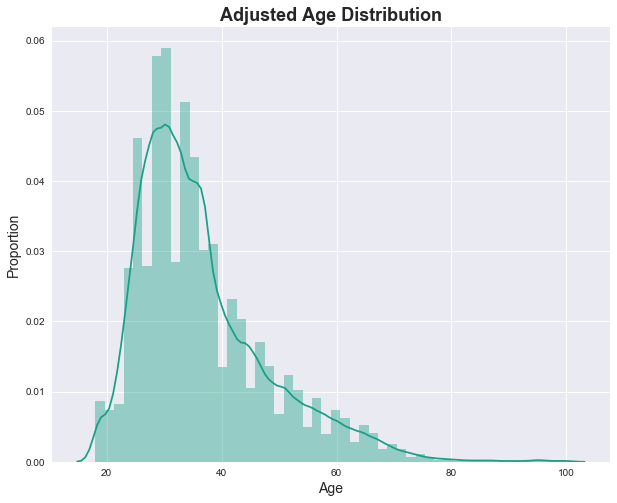

In [166]:
sns.distplot(users['age'].apply(lambda x : train_mean_age if x>100 or x < 18 else x).dropna(), color='#16A085')
plt.xlabel('Age', fontsize=14)  #Consider titling simply 'Age'
plt.ylabel('Proportion', fontsize=14)
plt.title('Adjusted Age Distribution', fontsize=18, fontweight='bold')

(10, 60)

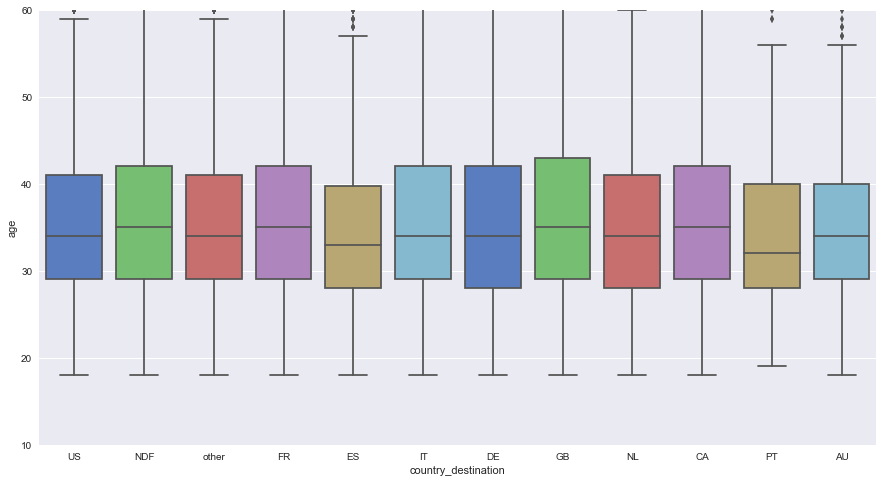

In [175]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(15, 8))
sns.boxplot(x='country_destination', y='age', data=xtrain, palette="muted", ax =ax)
ax.set_ylim([10, 60])

**Signup Method**

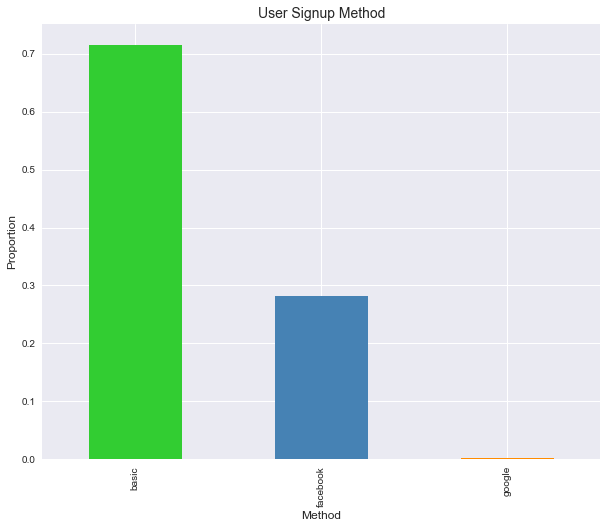

In [179]:
xtrain['signup_method'].value_counts(normalize=True, dropna=False).plot(kind='bar', color=['#32CD32','#4682B4','#FF8C00'])
plt.title('User Signup Method', fontsize=14)
plt.xlabel('Method', fontsize=12)
plt.ylabel('Proportion', fontsize=12)

In [170]:
test.signup_method.value_counts(normalize=True, dropna=False)

basic       0.729918
facebook    0.239242
google      0.030469
weibo       0.000370
Name: signup_method, dtype: float64

In [171]:
keep = ['basic','facebook','google']
# Prevents columns contained in test set but not in training set from causing issues
test.loc[~test.signup_method.isin(keep),'signup_method'] = np.nan

In [416]:
test.signup_method.value_counts(normalize=True, dropna=False)

basic       0.729918
facebook    0.239242
google      0.030469
weibo       0.000370
Name: signup_method, dtype: float64

In [27]:
keep = ['basic','facebook','google']
# Prevents columns contained in test set but not in training set from causing issues
test.loc[~test.signup_method.isin(keep),'signup_method'] = np.nan

Signup Method is a rather straightforward dummy case, and there are no null values to fill in for, as per the null value analysis done previously in the notebook.

In [28]:
xtrain['signup_flow'].value_counts(normalize=True, dropna=False)

0     0.771598
25    0.068880
12    0.043816
3     0.041210
2     0.032109
24    0.020502
23    0.013147
1     0.004878
6     0.001482
8     0.001113
21    0.000925
5     0.000170
20    0.000070
16    0.000047
15    0.000041
4     0.000006
10    0.000006
Name: signup_flow, dtype: float64

In [420]:
# Replace values consisting of less than 0.1% of the data with the 'signup_flow' mode, 0
replace_vals = np.arange(1,25,1)
xtrain.signup_flow.replace(to_replace=replace_vals, value='other', inplace=True)
xtest.signup_flow.replace(to_replace=replace_vals, value='other', inplace=True)
test.signup_flow.replace(to_replace=replace_vals, value='other', inplace=True)

In [29]:
# Replace values consisting of less than 0.1% of the data with the 'signup_flow' mode, 0
replace_vals = np.arange(1,25,1)
xtrain.signup_flow.replace(to_replace=replace_vals, value='other', inplace=True)
xtest.signup_flow.replace(to_replace=replace_vals, value='other', inplace=True)
test.signup_flow.replace(to_replace=replace_vals, value='other', inplace=True)

In [30]:
dummies.append('signup_flow')

**Language**

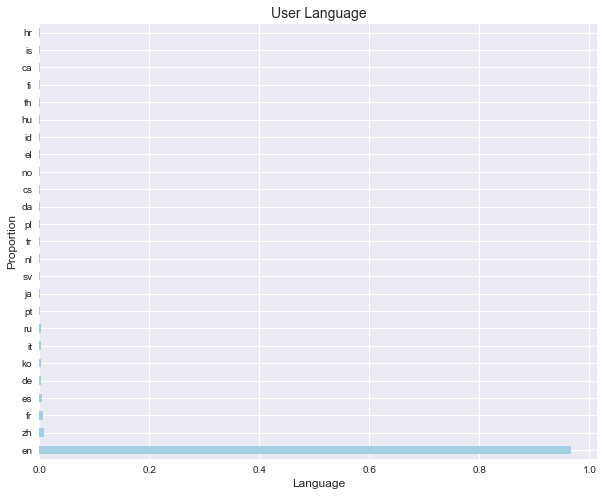

In [141]:
xtrain['language'].value_counts(normalize=True, dropna=False).plot(kind='barh',colormap='Paired')
plt.title('User Language', fontsize=14)
plt.xlabel('Language', fontsize=12)
plt.ylabel('Proportion', fontsize=12)

Since 96% of all users speak English, the language variable may provide little insight. Making dummies for all of the languages seems illogical. We could consider creating dummies for English (eh), Chinese (zh), and an 'other' category.

In [32]:
xtrain.language = xtrain.language.apply(lambda x: x if str(x) == 'en' or str(x) == 'zh' else 'other')
xtest.language = xtest.language.apply(lambda x: x if str(x) == 'en' or str(x) == 'zh' else 'other')
test.language = test.language.apply(lambda x: x if str(x) == 'en' or str(x) == 'zh' else 'other')

In [33]:
dummies.append('language')

**Affiliate Channel**

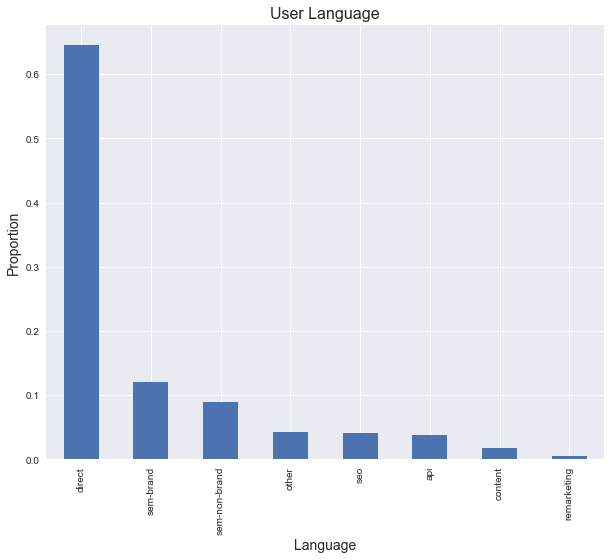

In [185]:
xtrain.affiliate_channel.value_counts(normalize=True, dropna=False).plot(kind='bar')# note 'api' isn't in test data
plt.title('User Language', fontsize=16)
plt.xlabel('Language', fontsize=14)
plt.ylabel('Proportion', fontsize=14)

In [35]:
keep2 = test.affiliate_channel.unique()
xtrain.loc[~xtrain.affiliate_channel.isin(keep2),'affiliate_channel'] = np.nan
xtest.loc[~xtest.affiliate_channel.isin(keep2),'affiliate_channel'] = np.nan

In [36]:
dummies.append('affiliate_channel')

**Affiliate Provider**

In [37]:
xtrain.affiliate_provider.value_counts(normalize=True, dropna=False)

direct                 0.643640
google                 0.241614
other                  0.059241
craigslist             0.016544
bing                   0.011097
facebook               0.010606
vast                   0.003842
padmapper              0.003613
facebook-open-graph    0.002588
yahoo                  0.002290
gsp                    0.002073
meetup                 0.001628
email-marketing        0.000755
naver                  0.000234
baidu                  0.000129
yandex                 0.000070
wayn                   0.000029
daum                   0.000006
Name: affiliate_provider, dtype: float64

In [38]:
#??? Either make dummies for all or only the categories consisting of more than 3%
xtrain.affiliate_provider = xtrain.affiliate_provider.apply(lambda x: x if str(x) == 'direct' or str(x) == 'google'
                                                           else 'other' )
xtest.affiliate_provider = xtest.affiliate_provider.apply(lambda x: x if str(x) == 'direct' or str(x) == 'google'
                                                           else 'other' )
test.affiliate_provider = test.affiliate_provider.apply(lambda x: x if str(x) == 'direct' or str(x) == 'google'
                                                           else 'other' )
dummies.append('affiliate_provider')

**First Affiliate Tracked**

First marketing interacted with by the user before signing up.

In [39]:
xtrain.first_affiliate_tracked.value_counts(normalize=True, dropna=False)

untracked        0.510606
linked           0.217270
omg              0.206055
tracked-other    0.029035
NaN              0.028789
product          0.007408
marketing        0.000673
local ops        0.000164
Name: first_affiliate_tracked, dtype: float64

In [40]:
# Fills null values with variable mode, which is 'untracked'
xtrain.first_affiliate_tracked.fillna(value='{}'.format(xtrain.first_affiliate_tracked.mode()[0]),inplace=True)
xtest.first_affiliate_tracked.fillna(value='{}'.format(xtrain.first_affiliate_tracked.mode()[0]),inplace=True)
test.first_affiliate_tracked.fillna(value='{}'.format(xtrain.first_affiliate_tracked.mode()[0]),inplace=True)
dummies.append('first_affiliate_tracked')

**Signup App**

In [41]:
xtrain.signup_app.value_counts(normalize=True, dropna=False)

Web        0.855651
iOS        0.089506
Moweb      0.029351
Android    0.025492
Name: signup_app, dtype: float64

In [42]:
dummies.append('signup_app')

**First Device Type**

In [43]:
xtrain.first_device_type.value_counts(normalize=True, dropna=False)

Mac Desktop           0.419320
Windows Desktop       0.340976
iPhone                0.097242
iPad                  0.067071
Other/Unknown         0.050158
Android Phone         0.013317
Android Tablet        0.006108
Desktop (Other)       0.005452
SmartPhone (Other)    0.000357
Name: first_device_type, dtype: float64

In [44]:
dummies.append('first_device_type')

**First Browser**

In [45]:
xtrain.first_browser.value_counts(normalize=True, dropna=False)

Chrome                  0.298969
Safari                  0.210957
Firefox                 0.157900
-unknown-               0.127987
IE                      0.098969
Mobile Safari           0.090015
Chrome Mobile           0.006196
Android Browser         0.004035
AOL Explorer            0.001113
Opera                   0.000896
Silk                    0.000597
Chromium                0.000328
BlackBerry Browser      0.000246
Maxthon                 0.000240
Apple Mail              0.000176
Mobile Firefox          0.000152
IE Mobile               0.000152
Sogou Explorer          0.000146
SiteKiosk               0.000141
RockMelt                0.000123
Iron                    0.000082
Pale Moon               0.000064
IceWeasel               0.000059
Yandex.Browser          0.000053
Camino                  0.000047
CometBird               0.000047
TenFourFox              0.000041
SeaMonkey               0.000035
wOSBrowser              0.000035
CoolNovo                0.000035
Opera Mini

In [46]:
vlist = ['Chrome', 'Safari', '-unknown-', 'Firefox', 'Mobile Safari', 'IE']
xtrain.first_browser = xtrain.first_browser.apply(lambda x: x if str(x) in vlist else 'other')
xtest.first_browser = xtest.first_browser.apply(lambda x: x if str(x) in vlist else 'other')
test.first_browser = test.first_browser.apply(lambda x: x if str(x) in vlist else 'other')

In [47]:
dummies.append('first_browser')

**Where possible, we should make sure the 'NDF' group is comparable on other observable characteristics. We can go back and add visualizations in the data cleaning section**

In [48]:
xtrain.country_destination.value_counts(normalize=True, dropna=False)

NDF      0.583860
US       0.291936
other    0.047365
FR       0.023501
IT       0.013311
GB       0.010699
ES       0.010529
CA       0.006752
DE       0.004995
NL       0.003555
AU       0.002489
PT       0.001007
Name: country_destination, dtype: float64

In [49]:
test_ids = test['id'].to_frame()

In [50]:
xtrain.drop(drop, axis=1, inplace=True)
xtest.drop(drop, axis=1, inplace=True)
test.drop(drop[2:], axis=1, inplace=True)

In [51]:
xtrain = pd.get_dummies(xtrain, columns=dummies, dummy_na=False)
xtest = pd.get_dummies(xtest, columns=dummies, dummy_na=False)
test = pd.get_dummies(test, columns=dummies, dummy_na=False)

## Modeling

### Binary Classification: To Book or Not to Book?

We first create a binary classification model to predict whether or not an individual will book an Airbnb. Our second model will then classify to which country a user will first visit given that they book a trip.

#### K-Neighbors Classifier

In [52]:
kn_clf = KNeighborsClassifier()

In [53]:
gridsearch_kn = GridSearchCV(kn_clf, {"n_neighbors": [3,5,7], "weights": ['uniform', 'distance'],
                                  "p":[1,2,3]})
%time gridsearch_kn.fit(xtrain, ytrain)
print("Best Parameters: {}".format(gridsearch_kn.best_params_))
knclf_ypredict_train = gridsearch_kn.predict(xtrain)
print("Training Accuracy Score: {}".format(metrics.accuracy_score(ytrain, knclf_ypredict_train)))
knclf_ypredict_test = gridsearch_kn.predict(xtest)
print("Test Accuracy Score: {}".format(metrics.accuracy_score(ytest, knclf_ypredict_test)))

CPU times: user 8min 22s, sys: 10.9 s, total: 8min 33s
Wall time: 42min 33s
Best Parameters: {'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}
Training Accuracy Score: 0.6754567814476459
Test Accuracy Score: 0.5395516619427982


#### Random Forest

In [54]:
rf_clf = RandomForestClassifier()
gridsearch_rf = GridSearchCV(rf_clf, {"n_estimators": [60, 100, 200], "class_weight": ['balanced', None],
                                      "max_depth": [7,9,11]})

In [55]:
%time gridsearch_rf.fit(xtrain, ytrain)
print("Best Parameters: {}".format(gridsearch_rf.best_params_))
rfclf_ypredict_train = gridsearch_rf.predict(xtrain)

CPU times: user 14min 48s, sys: 39.9 s, total: 15min 28s
Wall time: 15min 30s
Best Parameters: {'class_weight': None, 'max_depth': 11, 'n_estimators': 200}


In [56]:
print("Test Classification Report:")
rfclf_ypredict_test = gridsearch_rf.predict(xtest)
print(metrics.classification_report(ytest, rfclf_ypredict_test))

print("Train Accuracy: {}\nTest Accuracy: {}".format(metrics.accuracy_score(ytrain, rfclf_ypredict_train),
                                                    metrics.accuracy_score(ytest, rfclf_ypredict_test)))

Test Classification Report:
             precision    recall  f1-score   support

          0       0.68      0.80      0.74     24843
          1       0.63      0.49      0.55     17848

avg / total       0.66      0.67      0.66     42691

Train Accuracy: 0.679509252752401
Test Accuracy: 0.6684312852826123


#### XGBoost

In [57]:
xgb_clf = xgb.XGBClassifier()

In [58]:
gridsearch_xgb = GridSearchCV(xgb_clf, {'n_estimators':[50,100,150],'max_depth':[3,5,7],'learning_rate':[.01,.05,.1]})

In [59]:
%time gridsearch_xgb.fit(xtrain, ytrain)
print("Best Parameters: {}".format(gridsearch_xgb.best_params_))

CPU times: user 1h 11min 19s, sys: 40.7 s, total: 1h 12min
Wall time: 1h 18min 41s
Best Parameters: {'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 150}


In [60]:
xgbclf_ypredict_train = gridsearch_xgb.predict(xtrain)

In [61]:
print("Test Classification Report:")
xgbclf_ypredict_test = gridsearch_xgb.predict(xtest)
print(metrics.classification_report(ytest, xgbclf_ypredict_test))

print("Train Accuracy: {}\nTest Accuracy: {}".format(metrics.accuracy_score(ytrain, xgbclf_ypredict_train),
                                                    metrics.accuracy_score(ytest, xgbclf_ypredict_test)))

Test Classification Report:
             precision    recall  f1-score   support

          0       0.69      0.79      0.74     24843
          1       0.63      0.51      0.57     17848

avg / total       0.67      0.67      0.67     42691

Train Accuracy: 0.6825720309205903
Test Accuracy: 0.6718512098568785


### Multiple Classification: Country Destination

In [62]:
# Selects xtrain indices from multiclass target2 and creates new ytrain series
ytrain2 = target2[xtrain.index][target2!='NDF']

In [63]:
xtrain2 = xtrain.loc[ytrain2.index]

In [64]:
ytest2 = target2[xtest.index][target2!='NDF']

In [65]:
xtest2 = xtest.loc[ytest2.index]

#### K-Neighbors Classifier

In [66]:
gridsearch_kn2 = GridSearchCV(kn_clf, {"n_neighbors": [5,7,9], "weights": ['uniform', 'distance'],
                                  "p":[1,2,3]})
%time gridsearch_kn2.fit(xtrain2, ytrain2)
print("Best Parameters: {}".format(gridsearch_kn2.best_params_))
knclf2_ypredict_train = gridsearch_kn2.predict(xtrain2)
print("Training Accuracy Score: {}".format(metrics.accuracy_score(ytrain2, knclf2_ypredict_train)))
knclf2_ypredict_test = gridsearch_kn2.predict(xtest2)
print("Test Accuracy Score: {}".format(metrics.accuracy_score(ytest2, knclf2_ypredict_test)))

CPU times: user 3min 2s, sys: 4.17 s, total: 3min 6s
Wall time: 3min 7s
Best Parameters: {'n_neighbors': 9, 'p': 1, 'weights': 'uniform'}
Training Accuracy Score: 0.7027300872502111
Test Accuracy Score: 0.6949238009861048


#### Random Forest

rf_clf2 = RandomForestClassifier()
gridsearch_rf2  = GridSearchCV(rf_clf2, {"n_estimators": [20,30,60,100], "class_weight": ['balanced', None],
                                      "max_depth": [3,5,7,9]})

In [68]:
gridsearch_rf2.fit(xtrain2, ytrain2)
print("Best Parameters: {}".format(gridsearch_rf2.best_params_))
rfclf2_ypredict_train = gridsearch_rf2.predict(xtrain2)

Best Parameters: {'class_weight': None, 'max_depth': 3, 'n_estimators': 20}


In [69]:
rfclf2_ypredict_test = gridsearch_rf2.predict(xtest2)
print("Train Accuracy: {}\nTest Accuracy: {}".format(metrics.accuracy_score(ytrain2, rfclf2_ypredict_train),
                                                    metrics.accuracy_score(ytest2, rfclf2_ypredict_test)))

Train Accuracy: 0.7015339150014073
Test Accuracy: 0.7017593007619901


#### XGBoost

In [70]:
gridsearch_xgb2 = GridSearchCV(xgb_clf, {'n_estimators':[10,30,60],'max_depth':[3,5,7],'learning_rate':[.01,.05,.1]})
%time gridsearch_xgb2.fit(xtrain2, ytrain2)
print("Best Parameters: {}".format(gridsearch_xgb2.best_params_))

CPU times: user 2h 5min 13s, sys: 39.3 s, total: 2h 5min 52s
Wall time: 2h 7min 31s
Best Parameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 10}


In [71]:
xgbclf2_ypredict_train = gridsearch_xgb2.predict(xtrain2)
print("Test Classification Report:")
xgbclf2_ypredict_test = gridsearch_xgb2.predict(xtest2)
print(metrics.classification_report(ytest2, xgbclf2_ypredict_test))

print("Train Accuracy: {}\nTest Accuracy: {}".format(metrics.accuracy_score(ytrain2, xgbclf2_ypredict_train),
                                                    metrics.accuracy_score(ytest2, xgbclf2_ypredict_test)))

Test Classification Report:
             precision    recall  f1-score   support

         AU       0.00      0.00      0.00       114
         CA       0.00      0.00      0.00       275
         DE       0.00      0.00      0.00       208
         ES       0.00      0.00      0.00       451
         FR       0.00      0.00      0.00      1010
         GB       0.00      0.00      0.00       497
         IT       0.00      0.00      0.00       562
         NL       0.00      0.00      0.00       155
         PT       0.00      0.00      0.00        45
         US       0.70      1.00      0.82     12525
      other       0.00      0.00      0.00      2006

avg / total       0.49      0.70      0.58     17848

Train Accuracy: 0.7015339150014073
Test Accuracy: 0.7017593007619901


/Users/Elijah/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Predictions

In [72]:
# Binary classification model to predict which users will book
book_predictions = gridsearch_rf.best_estimator_.predict(test)

In [73]:
predictions_df = pd.DataFrame(data=book_predictions, columns=['Booked'])
predictions_df['Booked'].value_counts(normalize=True)

0    0.773061
1    0.226939
Name: Booked, dtype: float64

In [74]:
country_predictions = gridsearch_rf2.best_estimator_.predict(test)

In [75]:
test_ids['country'] = country_predictions

In [76]:
# Fills the users destination whom were predicted not to book with 'NDF' 
test_ids.loc[predictions_df[predictions_df['Booked']==0].index,'country'] = 'NDF'

In [77]:
test_ids.country.value_counts(normalize=True)

NDF    0.773061
US     0.226939
Name: country, dtype: float64

In [78]:
test_ids.head()

,id,country
0,5uwns89zht,NDF
1,jtl0dijy2j,NDF
2,xx0ulgorjt,NDF
3,6c6puo6ix0,NDF
4,czqhjk3yfe,NDF


In [79]:
test_ids.to_csv('submission1.csv', index=False)

**Attempting a Neural Net**

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, BatchNormalization
from keras.utils import np_utils
from keras.datasets import mnist
from sklearn.metrics import confusion_matrix
import numpy as np
from __future__ import division

model = Sequential([
    Dense(128, input_shape=(784,), activation='elu', kernel_initializer='he_normal'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(64, activation='elu', kernel_initializer='he_normal'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy')

model.fit(x_train, y_train, epochs=20, batch_size=64, validation_split=0.1)

test_predictions = np.argmax(model.predict(x_test),1)
y_test_sparse = np.argmax(y_test, 1)

confusion_matrix(y_test_sparse, test_predictions)

np.sum(y_test_sparse == test_predictions) / test_predictions.shape